#### Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import joblib
import csv
import datetime

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pprint import pprint

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Histamine H3 receptor

In [3]:
H3 = df[df.TargetName.eq('Histamine H3 receptor')]

In [4]:
H3.head(1)

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96


In [5]:
H3.shape

(961, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000188F28351C8>]],
      dtype=object)

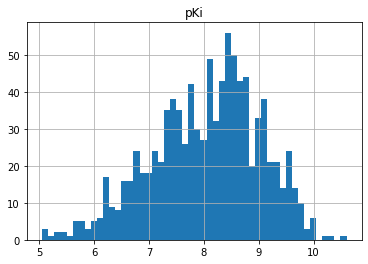

In [6]:
H3.hist('pKi', bins = 50)

#### Build a molecule record from smiles strings

In [7]:
#for index, row in H3.iterrows():
#    H3.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])
PandasTools.AddMoleculeColumnToFrame(H3, smilesCol = "SMILES")

C:\Users\us16120\Anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi,ROMol
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96,

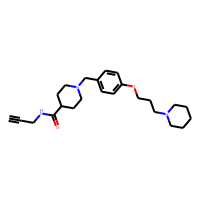

In [8]:
H3.head(1)

#### Calculate fingerprints

In [9]:
radius = 2
nBits = 1024

In [10]:
ECFP4 = [AllChem.GetMorganFingerprintAsBitVect(x, radius = radius, nBits = nBits) for x in H3['ROMol']]

In [11]:
ecfp4_names = [f'Bit_{i}' for i in range(nBits)]
ecfp4_bits = [list(l) for l in ECFP4]
H3_ecfp4 = pd.DataFrame(ecfp4_bits, index = H3.SMILES, columns = ecfp4_names)

In [12]:
H3_ecfp4.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
H3_pKi = H3[['SMILES', 'pKi']]
H3_pKi.set_index('SMILES', inplace = True)

In [14]:
H3_pKi.head(1)

,pKi
SMILES,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96


In [15]:
H3_Xy = H3_pKi.merge(H3_ecfp4, on = 'SMILES')

In [16]:
H3_Xy.head(1)

,pKi,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(H3.loc[1558, 'ROMol'], radius=2, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[2, 13, 80, 93, 102, 197, 257, 310, 322, 550]

In [18]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

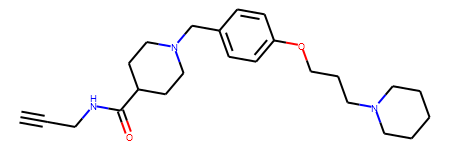

In [19]:
H3.loc[1558, 'ROMol']

In [20]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(H3.loc[1558, 'ROMol']),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 93, 102, 197, 257, 310, 322, 550, 650…

#### Build training and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(H3_Xy.drop(['pKi'], axis = 1), H3_Xy['pKi'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [22]:
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
pd.DataFrame(y_train).head(3)

,pKi
SMILES,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64


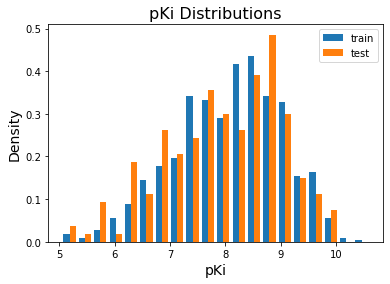

In [24]:
# create dataframe, select columns
df1x = pd.to_numeric(pd.DataFrame(y_train)['pKi'])
df2x = pd.to_numeric(pd.DataFrame(y_test)['pKi'])
#Stack the data
plt.figure()
plt.hist([df1x,df2x], bins = 20, stacked = False, density = True)
plt.title('pKi Distributions', fontsize = 16)
plt.xlabel('pKi', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

#### Random Forest Regression

##### Load libraries

In [25]:
from sklearn.ensemble import RandomForestRegressor

##### Create random forest regressor

In [26]:
rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

In [27]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [36]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


##### Train model - no hyperparameter optimization

In [28]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
rf.score(X_train, y_train)

0.939176110410782

In [30]:
rf.score(X_test, y_test)

0.646795005135183

In [31]:
predict_train = pd.DataFrame(rf.predict(X_train).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(rf.predict(X_test).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

expt_train = pd.DataFrame(y_train)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(y_test)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [32]:
pred.reset_index(inplace = True, drop = True)
expt.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'Experimental pKi')

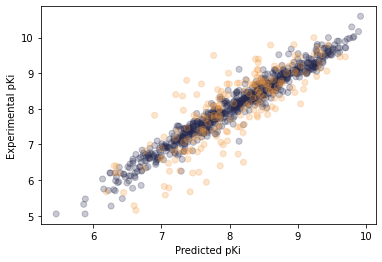

In [33]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

#### SHAP

In [34]:
import shap

In [35]:
# load JS visualization code to notebook
shap.initjs()

In [36]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train, check_additivity = False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


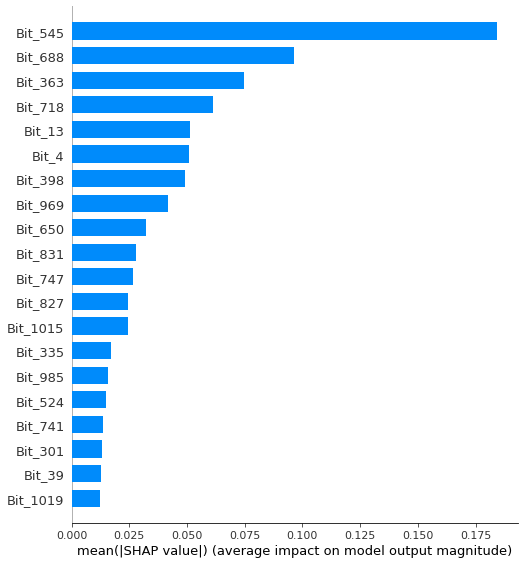

In [37]:
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

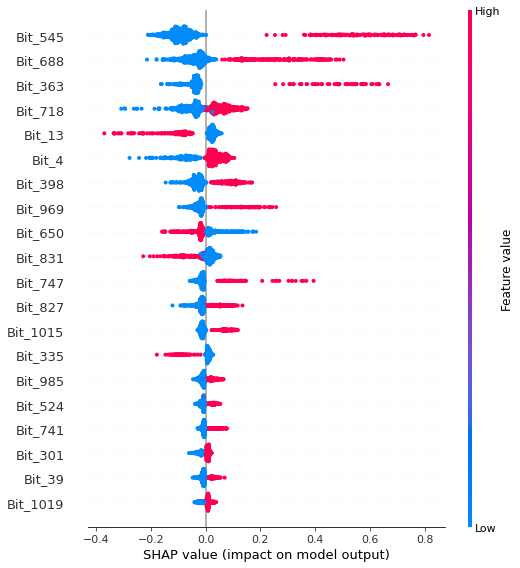

In [38]:
shap.summary_plot(shap_values, X_train)

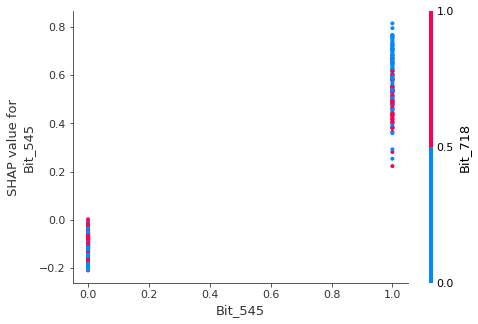

In [39]:
shap.dependence_plot("Bit_545", shap_values, X_train)

In [41]:
# Get the predictions and put them in with the test data
X_output = X_train.copy()
X_output.loc[:, 'predict'] = np.round(rf.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 500, 25)
qaz = X_output.iloc[random_picks]
qaz

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,predict
SMILES,,,,,,,,,,,,,,,,,,,,,
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.33
CC1CCN(CC1)CCCOCCCOc2ccc(cc2)Cl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.10
CCN1CCOC(C1)COc2ccc(cc2)CN3CCOCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.99
CC1CCN(CC1)Cc2ccc(cc2)c3ccc(cc3)CN4CCC(CC4)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.06
CC(C)N1CCN(CC1)C(=O)c2ccc(cc2)CN3CCC(CC3)F,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.78
CC1CCCN1CCCOc2ccc(cc2)C(=O)CN3CCN(CC3)C(=O)C(F)(F)F,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.61
c1cc2c(cc1OC3CCS(=O)(=O)C3)CCC4(O2)CCN(CC4)C5CCC5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.77
CC1CCCN1CCc2cc3cc(ccc3o2)C(=O)c4ccccc4,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,9.44
CC(C)N1CCN(CC1)C(=O)c2csc(n2)CN3CCOCC3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.45


In [45]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(qaz)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], qaz.iloc[[j]])
    return(p)

In [54]:
y_train.mean()

8.064960937500013

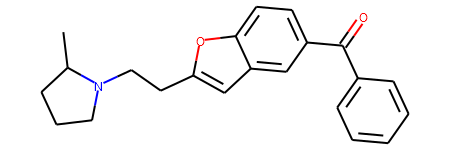

In [46]:
m = Chem.MolFromSmiles('CC1CCCN1CCc2cc3cc(ccc3o2)C(=O)c4ccccc4')
m

In [47]:
shap_plot(7)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [48]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[4,
 9,
 33,
 64,
 80,
 105,
 121,
 175,
 219,
 285,
 300,
 301,
 356,
 361,
 389,
 437,
 446,
 456,
 545,
 580,
 594,
 650,
 656,
 673,
 677,
 690,
 719,
 726,
 734,
 741,
 751,
 784,
 786,
 807,
 831,
 849,
 863,
 875,
 888,
 893,
 910,
 926,
 935,
 961,
 998,
 1015,
 1019]

In [49]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(4, 9, 33, 64, 80, 105, 121, 175, 219, 285, 300, …

In [55]:
shap_plot(12)

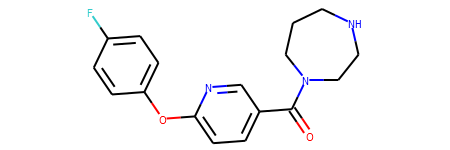

In [56]:
m2 = Chem.MolFromSmiles('c1cc(ccc1Oc2ccc(cn2)C(=O)N3CCCNCC3)F')
m2

In [57]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m2, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[4,
 56,
 90,
 142,
 193,
 284,
 305,
 311,
 322,
 356,
 361,
 366,
 369,
 378,
 386,
 428,
 456,
 480,
 492,
 494,
 497,
 511,
 546,
 593,
 628,
 646,
 650,
 673,
 695,
 699,
 718,
 726,
 744,
 772,
 807,
 849,
 893,
 897,
 904,
 926,
 935,
 942,
 985,
 996]

In [58]:
shap_plot(12)

In [59]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m2),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(4, 56, 90, 142, 193, 284, 305, 311, 322, 356, 36…

In [96]:
shap_v = pd.DataFrame(shap_values)
feature_list = X_train.columns
shap_v.columns = feature_list
X_train_v = X_train.copy().reset_index().drop('SMILES',axis=1)

In [97]:
X_train_v.head(5)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [98]:
# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i], X_train_v[i])[1][0]
    corr_list.append(b)
corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable', 'Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

invalid value encountered in true_divide
invalid value encountered in true_divide


In [99]:
corr_df.head()

,Variable,Corr,Sign
0,Bit_0,-0.996265,blue
1,Bit_1,-0.601283,blue
2,Bit_2,0.714128,red
3,Bit_3,0.318984,red
4,Bit_4,0.870418,red


Text(0.5, 0, 'SHAP Value (Red = Positive Impact)')

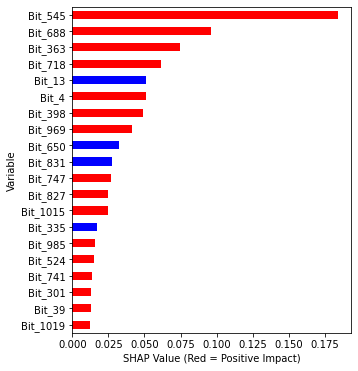

In [118]:
shap_abs = np.abs(shap_v)
k = pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df, left_on = 'Variable', right_on='Variable', how='inner')
k2 = k2.sort_values(by='SHAP_abs', ascending = True)

k3 = k2.tail(20)

colorlist = k3['Sign']
ax = k3.plot.barh(x='Variable', y='SHAP_abs', color = colorlist, figsize=(5,6), legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
# ABS_SHAP(shap_values,X_train) 

Text(0.5, 0, 'SHAP Value (Red = Positive Impact)')

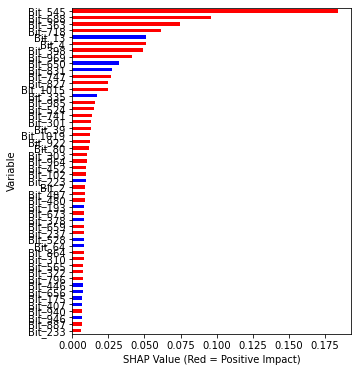

In [121]:
shap_abs = np.abs(shap_v)
k = pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df, left_on = 'Variable', right_on='Variable', how='inner')
k2 = k2.sort_values(by='SHAP_abs', ascending = True)

k3 = k2.tail(50)

colorlist = k3['Sign']
ax = k3.plot.barh(x='Variable', y='SHAP_abs', color = colorlist, figsize=(5,6), legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")

Text(0.5, 0, 'SHAP Value (Red = Positive Impact)')

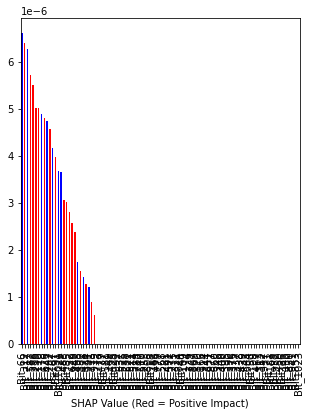

In [123]:
shap_abs = np.abs(shap_v)
k = pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df, left_on = 'Variable', right_on='Variable', how='inner')
k2 = k2.sort_values(by='SHAP_abs', ascending = False)

k3 = k2.tail(100)

colorlist = k3['Sign']
ax = k3.plot.bar(x='Variable', y='SHAP_abs', color = colorlist, figsize=(5,6), legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")